In [2]:
import os
import pandas as pd
import numpy as np
from enum import Enum
import torch
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F, init
from torch import optim
import torch.distributions as dist
import time
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
ROOT_DIR = os.path.realpath('./')
DATA_DIR = os.path.join(ROOT_DIR, 'data')
EDNET_KT1_DIR = os.path.join(DATA_DIR, 'ednet_kt1')
OUT_DIR = os.path.join(ROOT_DIR, 'out')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
EDNET_KT1_DIR = '/content/drive/MyDrive/kt1'
OUT_DIR = '/content/drive/MyDrive/kt1'

In [5]:
MISSING_DATA = -1

# Data Exploration

In [ ]:
def preprocess(dataset_file_name):
    cache_file = os.path.join(EDNET_KT1_DIR, dataset_file_name)
    if os.path.isfile(cache_file):
        return pd.read_csv(cache_file)
    
    responses = pd.read_csv(os.path.join(EDNET_KT1_DIR, f'unprocessed/{dataset_name}'))
    responses = responses[['timestamp', 'solving_id', 'question_id', 'user_answer', 'elapsed_time', 'user_id']]
    
    questions = pd.read_csv(os.path.join(EDNET_KT1_DIR, 'contents/questions.csv'))
    
    joined = pd.merge(responses, questions, how='inner', on=['question_id'])
    assert joined.shape[0] == responses.shape[0]
    
    joined.to_csv(cache_file, index=False)
    
    return joined

dataset_name = 'kt1_subset.csv'
raw_data = preprocess(dataset_name)
raw_data.head(2)

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,1552405824275,1,q5713,a,24000,u533092,b4245,e4245,a,5,71,1568635574409
1,1552405824275,1,q5713,a,24000,u533092,b4245,e4245,a,5,71,1568635574409


In [ ]:
raw_data = pd.read_csv(os.path.join(EDNET_KT1_DIR, dataset_name))
raw_data

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,1552405824275,1,q5713,a,24000,u533092,b4245,e4245,a,5,71,1568635574409
1,1552405824275,1,q5713,a,24000,u533092,b4245,e4245,a,5,71,1568635574409
2,1540785188092,2,q5713,a,15000,u298664,b4245,e4245,a,5,71,1568635574409
3,1559943082762,17,q5713,a,8000,u608719,b4245,e4245,a,5,71,1568635574409
4,1535867868674,246,q5713,a,34000,u248874,b4245,e4245,a,5,71,1568635574409
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1541769524423,420,q6827,d,22750,u295354,b5183,e5183,d,6,179;143,1564124620642
1048571,1503686797917,2470,q6827,c,61000,u21819,b5183,e5183,d,6,179;143,1564124620642
1048572,1534224187825,244,q6827,d,48250,u38390,b5183,e5183,d,6,179;143,1564124620642
1048573,1518238277613,897,q6827,d,44250,u37048,b5183,e5183,d,6,179;143,1564124620642


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   timestamp       1048575 non-null  int64 
 1   solving_id      1048575 non-null  int64 
 2   question_id     1048575 non-null  object
 3   user_answer     1048473 non-null  object
 4   elapsed_time    1048575 non-null  int64 
 5   user_id         1048575 non-null  object
 6   bundle_id       1048575 non-null  object
 7   explanation_id  1048575 non-null  object
 8   correct_answer  1048575 non-null  object
 9   part            1048575 non-null  int64 
 10  tags            1048575 non-null  object
 11  deployed_at     1048575 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 96.0+ MB


In [ ]:
print('The number of unique users:', len(raw_data['user_id'].unique()))
print('The number of unique questions:', len(raw_data['question_id'].unique()))

The number of unique users: 14592
The number of unique questions: 3399


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5cacf77d0>,
      dtype=object)

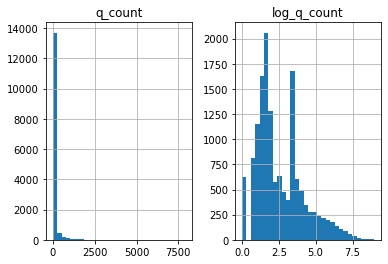

In [ ]:
q_count_by_u = raw_data.groupby(['user_id'])['question_id'].count().reset_index()
q_count_by_u.columns = ['user_id', 'q_count']
q_count_by_u['log_q_count'] = np.log(q_count_by_u['q_count'])
q_count_by_u.hist(bins=30)

In [ ]:
q_count_by_u.groupby('q_count')['user_id'].count().sort_values()

q_count
456       1
701       1
703       1
705       1
706       1
       ... 
6       889
3      1153
30     1169
5      1170
4      1629
Name: user_id, Length: 861, dtype: int64

In [ ]:
# Whether a user answers the same question more than 1 time?
count_by_u_q = raw_data.groupby(['user_id', 'question_id'])['user_answer'].count().reset_index()
count_by_u_q.columns = ['user_id', 'question_id', 'count']

print('The number of unique (user_id, question_id):', count_by_u_q.shape[0])
print(count_by_u_q['count'].unique())

print('Insight: Multiple responses per (user_id, question_id).')

The number of unique (user_id, question_id): 866603
[ 1  2  3  4  5  6  7  8  9  0 10 13 11 12 16 15 14 17 18 19 20]
Insight: Multiple responses per (user_id, question_id).


Insight: The visualization shows enough responses per question to learn unobserved question variables.


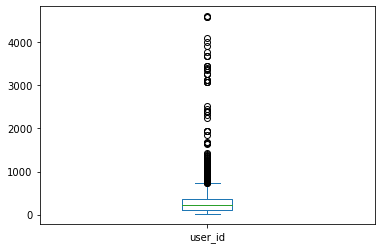

In [ ]:
raw_data.groupby('question_id')['user_id'].count().plot(kind='box')
print('Insight: The visualization shows enough responses per question to learn unobserved question variables.')

In [ ]:
raw_data['response'] = (raw_data['user_answer'] == raw_data['correct_answer'])
raw_data.groupby('response')['question_id'].count()

response
False    398118
True     650457
Name: question_id, dtype: int64

# Dataset Preparation

In [ ]:
class EdnetKT1(torch.utils.data.Dataset):
    def __init__(self, ds_file='kt1_subset.csv', train=True, binarized_response=True, swap_ability_item=False, **kwargs):
        super().__init__()
        
        self.swap_ability_item = swap_ability_item
        
        name, _ = os.path.splitext(ds_file)
        raw_data = pd.read_csv(os.path.join(EDNET_KT1_DIR, ds_file))
        
        responses = self.make_score_matrix(raw_data, name=name)
        
        rs = np.random.RandomState(42)
        swapper = np.arange(responses.shape[0])
        rs.shuffle(swapper)
        responses = responses[swapper]
        
        self.binarized_response = binarized_response
        if binarized_response:
            responses = np.round(responses)
            
        num_users = responses.shape[0]
        num_train = int(0.7 * num_users)
        
        if train:
            responses = responses[:num_train]
        else:
            responses = responses[num_train:]
        
        response_mask = np.ones_like(responses)
        response_mask[responses == MISSING_DATA] = 0
 
        self.responses = responses
        self.mask = response_mask
        self.length = responses.shape[0]
        self.num_person = responses.shape[0]
        self.num_item = responses.shape[1]
            
    def make_score_matrix(self, raw_data, name):
        cache_file = os.path.join(EDNET_KT1_DIR, f'{name}_score_matrix_swap{self.swap_ability_item}.npy'.lower())
        if os.path.isfile(cache_file):
            return np.load(cache_file)
        
        raw_data['response'] = 0
        raw_data.loc[raw_data['user_answer'] == raw_data['correct_answer'], 'response'] = 1
        
        compact_score_mat = raw_data.groupby(['user_id', 'question_id'])['response'].mean().reset_index()
        score_mat = compact_score_mat.pivot(index='user_id', columns='question_id', values='response')
        score_mat = score_mat.fillna(MISSING_DATA)
        score_mat = score_mat.values
        
        if self.swap_ability_item:
            score_mat = np.transpose(score_mat)
                
        np.save(cache_file, score_mat)
        return score_mat
    
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        response = self.responses[index]
        item_id = np.arange(self.num_item)
        item_id[response == MISSING_DATA] = MISSING_DATA
        mask = self.mask[index]

        response = torch.from_numpy(response).float().unsqueeze(1)
        item_id = torch.from_numpy(item_id).long().unsqueeze(1)
        mask = torch.from_numpy(mask).bool().unsqueeze(1)

        return index, response, item_id, mask

In [42]:
import scipy.sparse

class EdnetKT1Compressed(torch.utils.data.Dataset):
    def __init__(self, ds_file='kt1_data_0.npz', train=True, maskperc=0.3, binarized_response=True, swap_ability_item=False, **kwargs):
        super().__init__()

        self.swap_ability_item = swap_ability_item

        raw_data = scipy.sparse.load_npz(os.path.join(EDNET_KT1_DIR, ds_file)).todok()

        rs = np.random.RandomState(42)
        swapper = np.arange(100000)
        rs.shuffle(swapper)

        num_users = 100000 # responses.shape[0]
        num_train = int(0.7 * num_users)

        if train:
            index_map = swapper[:num_train]
        else:
            index_map = swapper[num_train:]

        self.index_map = index_map
        self.responses = raw_data
        self.length = len(self.index_map) #raw_data.shape[0]
        self.num_person = len(self.index_map) # raw_data.shape[0]
        self.num_item = raw_data.shape[1]
        self.maskperc = maskperc

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        full = self.responses[self.index_map[index], :]
        full_size = full.getnnz()
        unmask_size = int(full_size * (1-self.maskperc))
        rs = np.random.RandomState(42)
        swapper = np.arange(full_size)
        rs.shuffle(swapper)
        masked = swapper[unmask_size:]
        data_indices = self.responses[self.index_map[index], :].nonzero()
        not_keep = (data_indices[0][masked], data_indices[1][masked])
        not_keep_indices = [x for x in zip(*not_keep)]
        response = self.responses[self.index_map[index], :].toarray()
        missing_mask = np.zeros(response.shape, dtype=bool)
        missing_mask[not_keep] = 1
        missing_data = missing_mask * response - 1
        response = response - 1
        response[not_keep] = -1
        mask = np.zeros(response.shape, dtype=bool)
        mask[data_indices] = 1
        mask[not_keep] = 0
        return missing_data.transpose(), response.transpose(), missing_mask.transpose(), mask.transpose()


In [7]:
import copy

def artificially_mask_dataset(old_dataset, perc):
    dataset = copy.deepcopy(old_dataset)
    assert perc >= 0 and perc <= 1
    response = dataset.responses
    mask = dataset.mask

    if np.ndim(mask) == 2:
        row, col = np.where(mask != 0)
    elif np.ndim(mask) == 3:
        row, col = np.where(mask[:, :, 0] != 0)
    pool = np.array(list(zip(row, col)))
    num_all = pool.shape[0]
    num = int(perc * num_all)
    
    rs = np.random.RandomState(42)
    indices = np.sort(
        rs.choice(np.arange(num_all), size=num, replace=False),
    )
    label_indices = pool[indices]
    labels = []
    for idx in label_indices:
        label = copy.deepcopy(response[idx[0], idx[1]])
        labels.append(label)
        mask[idx[0], idx[1]] = 0
        response[idx[0], idx[1]] = -1
    labels = np.array(labels)

    dataset.response = response
    dataset.mask = mask
    dataset.missing_labels = labels
    dataset.missing_indices = label_indices

    return dataset

# Implementation

## Configurations

In [54]:
### Configurations ###

irt_model = '2pl'           # Available values: '1pl', '2pl' and '3pl'
dataset = 'ednet-kt1'
ability_dim = 8
ability_merge = 'product'   # Available values: 'product' and 'mean'
conditional_posterior = True
generative_model = 'irt'    # Available values: 'irt', 'link', 'deep', 'residual'
response_dist = 'gaussian' # Available values: 'bernoulli' and 'gaussian'
drop_missing = False
artificial_missing_perc = 0.3
no_test = False
num_person = 70000
num_item = 13169
# num_person = len(raw_data['user_id'].unique()) * 0.7
# num_item = len(raw_data['question_id'].unique())
num_posterior_samples = 10
hidden_dim = 64
max_num_person = None
max_num_item = None
swap_ability_item = False

lr = 5e-3
batch_size = 32
epochs = 5
max_iters = -1
num_workers = 0
anneal_kl = False
beta_kl = 0.9

seed = 8
cuda = True
gpu_device = 0

torch.manual_seed(seed)
np.random.seed(seed)

num_person = None
num_item = None

if max_num_person is not None:
    max_num_person = int(max_num_person)

if max_num_item is not None:
    max_num_item = int(max_num_item)

## Model

In [55]:
class ItemInferenceNetwork(nn.Module):

    def __init__(self, num_item, item_feat_dim):
        super().__init__()

        self.mu_lookup = nn.Embedding(num_item, item_feat_dim)
        self.logvar_lookup = nn.Embedding(num_item, item_feat_dim)

    def forward(self, item_index):
        item_index = item_index.squeeze(1)
        mu = self.mu_lookup(item_index.long())
        logvar = self.logvar_lookup(item_index.long())

        return mu, logvar

def product_of_experts(mu, logvar, eps=1e-8):
    # assume the first dimension is the number of experts
    var = torch.exp(logvar) + eps
    T = 1 / var  # precision of i-th Gaussian expert at point x
    pd_mu = torch.sum(mu * T, dim=0) / torch.sum(T, dim=0)
    pd_var = 1 / torch.sum(T, dim=0)
    pd_logvar = torch.log(pd_var)

    return pd_mu, pd_logvar    

class AbilityInferenceNetwork(nn.Module):

    def __init__(
            self,
            ability_dim,
            response_dim,
            hidden_dim = 64,
            ability_merge = 'mean',
            replace_missing_with_prior = True,
        ):
        super().__init__()

        self.ability_dim = ability_dim
        self.response_dim = response_dim
        self.hidden_dim = hidden_dim
        self.ability_merge = ability_merge
        self.replace_missing_with_prior = replace_missing_with_prior

        getattr(self, f'_create_models_{self.ability_merge}')(
            self.response_dim, 
            self.hidden_dim,
            self.ability_dim * 2,
        )

    def _create_models_product(self, input_dim, hidden_dim, output_dim):
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(hidden_dim, output_dim),
        )
    
    def _create_models_mean(self, input_dim, hidden_dim, output_dim):
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(hidden_dim, output_dim),
        )
    
    def _forward_product(self, mlp_input, mask, num_person, num_item):
        has_missing = bool(torch.sum(1 - mask).item()) if mask is not None else False

        mu_flat, logvar_flat = torch.chunk(self.mlp(mlp_input), 2, dim=1)
        mu_set = mu_flat.view(num_person, num_item, self.ability_dim)
        logvar_set = logvar_flat.view(num_person, num_item, self.ability_dim)

        p_mu_set = torch.zeros_like(mu_set)
        p_logvar_set = 2. * torch.log(torch.ones_like(logvar_set) * 0.25)

        if has_missing:
            mu, logvar = [], []
            for i in range(num_person):
                if mask[i].sum().item() != num_item:
                    mask_i = mask[i].bool().repeat(1, self.ability_dim)
                    mu_set_i = mu_set[i][mask_i].view(-1, self.ability_dim)
                    logvar_set_i = logvar_set[i][mask_i].view(-1, self.ability_dim)
                    # replace all missing items with a prior score
                    if self.replace_missing_with_prior:
                        p_mu_set_i = p_mu_set[i][~mask_i].view(-1, self.ability_dim)
                        p_logvar_set_i = p_logvar_set[i][~mask_i].view(-1, self.ability_dim)
                        mu_set_i = torch.cat([mu_set_i, p_mu_set_i], dim=0)
                        logvar_set_i = torch.cat([logvar_set_i, p_logvar_set_i], dim=0)
                        assert mu_set_i.size(0) == num_item
                        assert logvar_set_i.size(0) == num_item
                else:
                    mu_set_i, logvar_set_i = mu_set[i], logvar_set[i]
                mu_i, logvar_i = product_of_experts(mu_set_i, logvar_set_i)
                mu.append(mu_i); logvar.append(logvar_i)
            mu, logvar = torch.stack(mu), torch.stack(logvar)
        else:
            mu, logvar = product_of_experts(mu_set.permute(1, 0, 2), logvar_set.permute(1, 0, 2))

        return mu, logvar

    def _forward_mean(self, mlp_input, mask, num_person, num_item):
        has_missing = bool(torch.sum(1 - mask).item()) if mask is not None else False

        hid = F.elu(self.mlp1(mlp_input))
        hid = hid.view(num_person, num_item, self.hidden_dim)
        if has_missing:
            hid_mean = []
            for i in range(num_person):
                hid_i = hid[i][mask[i].repeat(1, self.hidden_dim).bool()]
                num_i = mask[i].squeeze().sum().item()
                hid_i = hid_i.view(num_i, self.hidden_dim)
                hid_i_mean = hid_i.mean(0)
                hid_mean.append(hid_i_mean)
            hid_mean = torch.stack(hid_mean)
        else:
            hid_mean = hid.mean(1)
     
        mu, logvar = torch.chunk(self.mlp2(hid_mean), 2, dim=1)
        
        return mu, logvar

    def forward(self, response, mask):
        num_person, num_item, response_dim = response.size()
        mlp_input = response.view(num_person * num_item, response_dim)

        return getattr(self, f'_forward_{self.ability_merge}')(
                mlp_input, 
                mask,
                num_person,
                num_item,
            )


class ConditionalAbilityInferenceNetwork(AbilityInferenceNetwork):

    def __init__(
            self, 
            ability_dim, 
            response_dim, 
            item_feat_dim, 
            hidden_dim = 64,
            ability_merge = 'mean',
            replace_missing_with_prior = True,
        ):
        super().__init__(
            ability_dim,
            response_dim,
            hidden_dim = hidden_dim,
            ability_merge = ability_merge,
            replace_missing_with_prior = replace_missing_with_prior,
        )
        self.ability_dim = ability_dim
        self.response_dim = response_dim
        self.item_feat_dim = item_feat_dim
        self.hidden_dim = hidden_dim
        self.ability_merge = ability_merge
        self.replace_missing_with_prior = replace_missing_with_prior

        getattr(self, f'_create_models_{self.ability_merge}')(
            self.response_dim + self.item_feat_dim, 
            self.hidden_dim,
            self.ability_dim * 2,
        )

    def forward(self, response, mask, item_feat):
        num_person, num_item, response_dim = response.size()
        item_feat_dim = item_feat.size(1)

        response_flat = response.view(num_person * num_item, response_dim)
        item_feat_flat = item_feat.unsqueeze(0).repeat(num_person, 1, 1)
        item_feat_flat = item_feat_flat.view(num_person * num_item, item_feat_dim)

        mlp_input = torch.cat([response_flat, item_feat_flat], dim=1)

        return getattr(self, f'_forward_{self.ability_merge}')(
                mlp_input, 
                mask,
                num_person,
                num_item,
            )

In [56]:
def standard_normal_log_pdf(x):
    mu = torch.zeros_like(x)
    scale = torch.ones_like(x)
    return torch.distributions.normal.Normal(mu, scale).log_prob(x)

def normal_log_pdf(x, mu, logvar):
    scale = torch.exp(0.5 * logvar)
    return torch.distributions.normal.Normal(mu, scale).log_prob(x)

def reparameterize_gaussian(mean, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mean)

def masked_bernoulli_log_pdf(x, mask, probs):
    dist = torch.distributions.bernoulli.Bernoulli(probs=probs)
    log_prob = dist.log_prob(x)
    return log_prob * mask.float()

def masked_gaussian_log_pdf(x, mask, mu, logvar):
    sigma = torch.exp(0.5 * logvar)
    dist = torch.distributions.normal.Normal(mu, sigma)
    log_prob = dist.log_prob(x)
    return log_prob * mask.float()

def kl_divergence_standard_normal_prior(z_mu, z_logvar):
    kl_div = -0.5 * (1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    kl_div = torch.sum(kl_div, dim=1)
    return kl_div

class LinkedIRT(nn.Module):

    def __init__(self, irt_model = '1pl', hidden_dim = 64):
        super().__init__()
        assert irt_model in ['1pl', '2pl', '3pl']
        self.irt_model = irt_model
        self.hidden_dim = hidden_dim
        self.link = nn.Sequential(
            nn.Linear(1, self.hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(self.hidden_dim, 1),
            nn.Sigmoid(),
        )
        self.apply(self.weights_init)

    def forward(self, ability, item_feat):
        if self.irt_model == '1pl':
            logit = irt_model_1pl(ability, item_feat, return_logit=True)
            response_mu = self.link(logit)
        
        elif self.irt_model == '2pl':
            logit = irt_model_2pl(ability, item_feat, return_logit=True)
            response_mu = self.link(logit)
            
        elif self.irt_model == '3pl':
            logit, guess = irt_model_3pl(ability, item_feat, return_logit=True)
            response_mu = guess + (1. - guess) * self.link(logit)
        
        else:
            raise Exception(f'Unsupported irt_model {self.irt_model}.')

        return response_mu

    @staticmethod
    def weights_init(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            init.xavier_normal_(m.weight.data, gain=init.calculate_gain('relu'))
            init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm1d):
            pass


class DeepIRT(nn.Module):

    def __init__(self, latent_dim, irt_model = '1pl', hidden_dim = 64):
        super().__init__()
        assert irt_model in ['1pl', '2pl', '3pl']
        self.latent_dim = latent_dim
        self.ability_dim = latent_dim
        self.irt_model = irt_model
        self.hidden_dim = hidden_dim

        if self.irt_model == '1pl':
            self.item_feat_dim = 1
        elif self.irt_model == '2pl':
            self.item_feat_dim = self.latent_dim + 1
        elif self.irt_model == '3pl':
            self.item_feat_dim = self.latent_dim + 2

        self.mlp_item_feat = nn.Sequential(
            nn.Linear(self.item_feat_dim, self.hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
        )
        self.mlp_ability = nn.Sequential(
            nn.Linear(self.ability_dim, self.hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
        )
        self.mlp_concat = nn.Sequential(
            nn.Linear(2 * self.hidden_dim, self.hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(inplace=True),
            nn.Linear(self.hidden_dim, 1),
        )
        self.apply(self.weights_init)
    
    def forward(self, ability, item_feat):
        num_person, num_item = ability.size(0), item_feat.size(0)

        hid_ability = self.mlp_ability(ability)
        hid_item_feat = self.mlp_item_feat(item_feat)
        
        hid_ability = hid_ability.unsqueeze(1).repeat(1, num_item, 1)
        hid_item_feat = hid_item_feat.unsqueeze(0).repeat(num_person, 1, 1)

        hid = torch.cat([hid_item_feat, hid_ability], dim=2)
        hid = self.mlp_concat(hid)
        response_mu = torch.sigmoid(hid)
        return response_mu

    @staticmethod
    def weights_init(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            init.xavier_normal_(m.weight.data, gain=init.calculate_gain('relu'))
            init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm1d):
            pass


class ResidualIRT(DeepIRT):
    
    def __init__(self, latent_dim, irt_model = '1pl', hidden_dim = 64):
        super().__init__(
            latent_dim, 
            irt_model = irt_model, 
            hidden_dim = hidden_dim,
        )
        self.apply(self.zero_init)

    def residual_forward(self, ability, item_feat):
        num_person, num_item = ability.size(0), item_feat.size(0)
        hid_ability = self.mlp_ability(ability)
        hid_item_feat = self.mlp_item_feat(item_feat)
        hid_ability = hid_ability.unsqueeze(1).repeat(1, num_item, 1)
        hid_item_feat = hid_item_feat.unsqueeze(0).repeat(num_person, 1, 1)
        hid = torch.cat([hid_item_feat, hid_ability], dim=2)
        return self.mlp_concat(hid)

    def forward(self, ability, item_feat):
        res_logit = self.residual_forward(ability, item_feat)

        if self.irt_model == '1pl':
            irt_logit = irt_model_1pl(ability, item_feat, return_logit=True)
            return torch.sigmoid(res_logit + irt_logit)

        elif self.irt_model == '2pl':
            irt_logit = irt_model_2pl(ability, item_feat, return_logit=True)
            return torch.sigmoid(res_logit + irt_logit)

        elif self.irt_model == '3pl':
            irt_logit, guess = irt_model_3pl(ability, item_feat, return_logit=True)
            return guess + (1. - guess) * torch.sigmoid(res_logit + irt_logit)
        
        else:
            raise Exception(f'Unsupported irt_model {self.irt_model}.')

    @staticmethod
    def zero_init(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            init.xavier_normal_(m.weight.data, gain=init.calculate_gain('relu'))
            init.constant(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm1d):
            pass

def irt_model_1pl(ability, item_feat, return_logit=False):
    difficulty = torch.sum(item_feat, dim=1, keepdim=True)
    logit = (torch.sum(ability, dim=1, keepdim=True) + difficulty.T).unsqueeze(2)
    if return_logit:
        return logit
    else:
        response_mu = torch.sigmoid(logit)
        return response_mu


def irt_model_2pl(ability, item_feat, return_logit=False):
    ability_dim = ability.size(1)
    discrimination = item_feat[:, :ability_dim]
    difficulty = item_feat[:, ability_dim:]
    logit = (torch.mm(ability, -discrimination.T) + difficulty.T).unsqueeze(2)
    
    if return_logit:
        return logit
    else:
        response_mu = torch.sigmoid(logit)
        return response_mu


def irt_model_3pl(ability, item_feat, return_logit=False):
    ability_dim = ability.size(1)
    discrimination = item_feat[:, :ability_dim]
    difficulty = item_feat[:, ability_dim:ability_dim+1]
    guess_logit = item_feat[:, ability_dim+1:ability_dim+2]
    guess = torch.sigmoid(guess_logit)
    logit = (torch.mm(ability, -discrimination.T) + difficulty.T).unsqueeze(2)
    
    if return_logit:
        return logit, guess
    else:
        guess = guess.unsqueeze(0)  
        response_mu = guess + (1. - guess) * torch.sigmoid(logit)
        return response_mu

class VIBO_1PL(nn.Module):
    
    def __init__(
            self, 
            latent_dim, 
            num_item, 
            hidden_dim = 64,
            ability_merge = 'mean',
            conditional_posterior = False,
            generative_model = 'irt',
            response_dist = 'bernoulli',
            replace_missing_with_prior = True,
        ):
        super().__init__()

        assert ability_merge in ['mean', 'product']
        assert generative_model in ['irt', 'link', 'deep', 'residual']
        assert response_dist in ['bernoulli', 'gaussian']

        self.latent_dim            = latent_dim
        self.ability_dim           = latent_dim
        self.response_dim          = 1
        self.hidden_dim            = hidden_dim
        self.num_item              = num_item
        self.ability_merge         = ability_merge
        self.conditional_posterior = conditional_posterior
        self.generative_model      = generative_model
        self.response_dist         = response_dist
        self.replace_missing_with_prior = replace_missing_with_prior

        self._set_item_feat_dim()
        self._set_irt_num()

        if self.conditional_posterior:
            self.ability_encoder = ConditionalAbilityInferenceNetwork(
                self.ability_dim, 
                self.response_dim, 
                self.item_feat_dim, 
                self.hidden_dim, 
                ability_merge = self.ability_merge,
                replace_missing_with_prior = self.replace_missing_with_prior,
            )
        else:
            self.ability_encoder = AbilityInferenceNetwork(
                self.ability_dim, 
                self.response_dim, 
                self.hidden_dim, 
                ability_merge = self.ability_merge,
                replace_missing_with_prior = self.replace_missing_with_prior,
            )

        self.item_encoder = ItemInferenceNetwork(self.num_item, self.item_feat_dim) 

        if self.generative_model == 'link':
            self.decoder = LinkedIRT(
                irt_model = f'{self.irt_num}pl',
                hidden_dim = self.hidden_dim,
            )
        elif self.generative_model == 'deep':
            self.decoder = DeepIRT(
                self.ability_dim,
                irt_model = f'{self.irt_num}pl',
                hidden_dim = self.hidden_dim,
            )
        elif self.generative_model == 'residual':
            self.decoder = ResidualIRT(
                self.ability_dim,
                irt_model = f'{self.irt_num}pl',
                hidden_dim = self.hidden_dim,
            )

        self.apply(self.weights_init)

    def _set_item_feat_dim(self):
        self.item_feat_dim = self.latent_dim

    def _set_irt_num(self):
        self.irt_num = 1

    def forward(self, response, mask):
        ability, ability_mu, ability_logvar, \
        item_feat, item_feat_mu, item_feat_logvar \
            = self.encode(response, mask)

        response_mu = self.decode(ability, item_feat)
        return response, mask, response_mu, \
            ability, ability_mu, ability_logvar, \
            item_feat, item_feat_mu, item_feat_logvar

    def encode(self, response, mask):
        device = response.device

        item_domain = torch.arange(self.num_item).unsqueeze(1).to(device)
        item_feat_mu, item_feat_logvar = self.item_encoder(item_domain)
        item_feat = reparameterize_gaussian(item_feat_mu, item_feat_logvar)

        if self.conditional_posterior:
            ability_mu, ability_logvar = self.ability_encoder(response, mask, item_feat) 
        else:
            ability_mu, ability_logvar = self.ability_encoder(response, mask)

        ability = reparameterize_gaussian(ability_mu, ability_logvar)

        return ability, ability_mu, ability_logvar, \
                item_feat, item_feat_mu, item_feat_logvar

    def decode(self, ability, item_feat):
        if self.generative_model == 'irt':
            response_mu = irt_model_1pl(ability, item_feat)
            return response_mu
        else:
            return self.decoder(ability, item_feat)

    def elbo(
            self, 
            response,
            mask, 
            response_mu, 
            ability, 
            ability_mu, 
            ability_logvar,
            item_feat, 
            item_feat_mu, 
            item_feat_logvar, 
            annealing_factor = 1,
            use_kl_divergence = True,
            ability_k = None,
            item_feat_k = None,
            ability_logabsdetjac = None,
            item_logabsdetjac = None,
        ):
        if self.response_dist == 'bernoulli':
            log_p_r_j_given_d_u = masked_bernoulli_log_pdf(response, mask, response_mu).sum()
        elif self.response_dist == 'gaussian':
            response_logvar = 2. * torch.log(torch.ones_like(response_mu) * 0.1)
            log_p_r_j_given_d_u = masked_gaussian_log_pdf(response, mask, response_mu, response_logvar).sum()
        else:
            raise Exception(f'response_dist {self.response_dist} not supported.')
        
        if use_kl_divergence:
            kl_q_u_p_u = kl_divergence_standard_normal_prior(ability_mu, ability_logvar).sum()
            kl_q_d_p_d = kl_divergence_standard_normal_prior(item_feat_mu, item_feat_logvar).sum()
            elbo = log_p_r_j_given_d_u - annealing_factor * kl_q_u_p_u - annealing_factor * kl_q_d_p_d

        else:
            log_p_u = standard_normal_log_pdf(ability).sum()
            log_p_d = standard_normal_log_pdf(item_feat).sum()
            log_q_u = normal_log_pdf(ability, ability_mu, ability_logvar).sum()
            log_q_d = normal_log_pdf(item_feat, item_feat_mu, item_feat_logvar).sum()

            model_log_prob_sum = log_p_r_j_given_d_u + log_p_u + log_p_d
            guide_log_prob_sum = log_q_u + log_q_d

            elbo = model_log_prob_sum - guide_log_prob_sum

        return -elbo

    def log_marginal(self, response, mask, num_samples=100):
        with torch.no_grad():
            log_weight = []
            for _ in range(num_samples):
                
                (
                    response, 
                    mask, 
                    response_mu, 
                    ability, 
                    ability_mu, 
                    ability_logvar,
                    item_feat, 
                    item_feat_mu, 
                    item_feat_logvar, 
                ) = self.forward(response, mask)
                ability_k = None
                item_feat_k = None
                ability_logabsdetjac = None
                item_feat_logabsdetjac = None

                log_w = -self.elbo(
                    response,
                    mask,
                    response_mu,
                    ability,
                    ability_mu,
                    ability_logvar,
                    item_feat,
                    item_feat_mu,
                    item_feat_logvar,
                    annealing_factor = 1,
                    use_kl_divergence = False,
                    ability_k = ability_k,
                    item_feat_k = item_feat_k,
                    ability_logabsdetjac = ability_logabsdetjac,
                    item_logabsdetjac = item_feat_logabsdetjac,
                )
                log_weight.append(log_w)

            log_weight = torch.stack(log_weight)
            logp = torch.logsumexp(log_weight, 0) - math.log(num_samples)

        return logp

    @staticmethod
    def weights_init(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            init.xavier_normal_(m.weight.data, gain=init.calculate_gain('relu'))
            init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm1d):
            pass


class VIBO_2PL(VIBO_1PL):

    def _set_item_feat_dim(self):
        self.item_feat_dim = self.latent_dim + 1

    def _set_irt_num(self):
        self.irt_num = 2

    def decode(self, ability, item_feat):
        if self.generative_model == 'irt':
            return irt_model_2pl(ability, item_feat)
        else:
            return self.decoder(ability, item_feat)


class VIBO_3PL(VIBO_2PL):

    def _set_item_feat_dim(self):
        self.item_feat_dim = self.latent_dim + 2

    def _set_irt_num(self):
        self.irt_num = 3

    def decode(self, ability, item_feat):        
        if self.generative_model == 'irt':
            return irt_model_3pl(ability, item_feat)
        else:
            return self.decoder(ability, item_feat)

In [57]:
out_file = 'VIBO_{}_{}_{}_{}_{}maskperc_{}ability_{}_{}_seed{}_conditional_posterior{}_batch_size{}_epochs{}_lr{}_anneal_kl{}_beta_kl{}'.format(
    irt_model, 
    dataset,
    response_dist,
    generative_model,
    artificial_missing_perc,
    ability_dim, 
    ability_merge,
    'conditional_q' if conditional_posterior else 'unconditional_q',
    seed,
    conditional_posterior,
    batch_size,
    epochs,
    lr,
    anneal_kl,
    beta_kl,
)
out_dir = os.path.join(OUT_DIR, out_file)
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    
device = torch.device('cuda' if cuda else 'cpu')
if cuda: torch.cuda.set_device(gpu_device)

train_dataset = EdnetKT1Compressed(train=True, maskperc=0.0, binarized_response=False, swap_ability_item=swap_ability_item)
test_dataset  = EdnetKT1Compressed(train=False, maskperc=artificial_missing_perc, binarized_response=False, swap_ability_item=swap_ability_item)

#if artificial_missing_perc > 0:
#    train_dataset = artificially_mask_dataset(
#        train_dataset,
#        artificial_missing_perc,
#    )

num_person = train_dataset.num_person
num_item = train_dataset.num_item

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = num_workers,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size = batch_size, 
    shuffle = False,
    num_workers = num_workers,
)
N_mini_batches = len(train_loader)
if max_iters != -1:
    epochs = int(math.ceil(max_iters / float(len(train_loader))))
    print(f'Found MAX_ITERS={max_iters}, setting EPOCHS={epochs}')

if irt_model == '1pl':
    model_class = VIBO_1PL
elif irt_model == '2pl':
    model_class = VIBO_2PL
elif irt_model == '3pl':
    model_class = VIBO_3PL
else:
    raise Exception(f'model {irt_model} not recognized')

model = model_class(
    ability_dim,
    num_item,
    hidden_dim = hidden_dim,
    ability_merge = ability_merge,
    conditional_posterior = conditional_posterior,
    generative_model = generative_model,
    response_dist = response_dist,
    replace_missing_with_prior = not drop_missing,
).to(device)

## Train

In [58]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, folder='./', filename='checkpoint.pth.tar'):
    if not os.path.isdir(folder):
        os.makedirs(folder)
    torch.save(state, os.path.join(folder, filename))
    if is_best:
        shutil.copyfile(os.path.join(folder, filename),
                        os.path.join(folder, 'model_best.pth.tar'))

In [59]:
def get_annealing_factor(epoch, which_mini_batch):
    if anneal_kl:
        annealing_factor = \
            (float(which_mini_batch + epoch * N_mini_batches + 1) /
             float(epochs // 2 * N_mini_batches))
    else:
        annealing_factor = beta_kl 
    return annealing_factor

def train(epoch):
    model.train()
    train_loss = AverageMeter()
    pbar = tqdm(total=len(train_loader))

    for batch_idx, (_, response, _, mask) in enumerate(train_loader):
        mb = response.size(0)
        response = response.to(device)
        mask = mask.long().to(device)
        annealing_factor = get_annealing_factor(epoch, batch_idx)

        optimizer.zero_grad()

        outputs = model(response, mask)
        loss = model.elbo(*outputs, annealing_factor=annealing_factor, use_kl_divergence=True)
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), mb)

        pbar.update()
        pbar.set_postfix({'Loss': train_loss.avg})

    pbar.close()
    print('====> Train Epoch: {} Loss: {:.4f}'.format(epoch, train_loss.avg))

    return train_loss.avg

def test(epoch):
    model.eval()
    test_loss = AverageMeter()
    pbar = tqdm(total=len(test_loader))

    with torch.no_grad():
        for _, response, _, mask in test_loader:
            mb = response.size(0)
            response = response.to(device)
            mask = mask.long().to(device)

            
            outputs = model(response, mask)
            loss = model.elbo(*outputs)
            test_loss.update(loss.item(), mb)

            pbar.update()
            pbar.set_postfix({'Loss': test_loss.avg})

    pbar.close()
    print('====> Test Epoch: {} Loss: {:.4f}'.format(epoch, test_loss.avg))

    return test_loss.avg

def get_log_marginal_density(loader):
    model.eval()
    meter = AverageMeter()
    pbar = tqdm(total=len(loader))

    with torch.no_grad():
        for _, response, _, mask in loader:
            mb = response.size(0)
            response = response.to(device)
            mask = mask.long().to(device)

            marginal = model.log_marginal(
                response, 
                mask, 
                num_samples=num_posterior_samples,
            )
            marginal = torch.mean(marginal)
            meter.update(marginal.item(), mb)

            pbar.update()
            pbar.set_postfix({'Marginal': meter.avg})

    pbar.close()
    print('====> Marginal: {:.4f}'.format(meter.avg))

    return meter.avg

In [60]:
optimizer = optim.Adam(model.parameters(), lr=lr)

is_best, best_loss = False, np.inf
train_losses = np.zeros(epochs)
if not no_test:
    test_losses  = np.zeros(epochs)
train_times = np.zeros(epochs)

for epoch in range(epochs):
    start_time = time.time()
    train_loss = train(epoch)
    end_time = time.time()
    train_losses[epoch] = train_loss
    train_times[epoch] = start_time - end_time

    if not no_test:
        test_loss = test(epoch)
        test_losses[epoch] = test_loss
        is_best = test_loss < best_loss
        best_loss = min(test_loss, best_loss)
    else:
        is_best = train_loss < best_loss
        best_loss = min(train_loss, best_loss)

    save_checkpoint({
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
    }, is_best, folder=out_dir)

    np.save(os.path.join(out_dir, 'train_losses.npy'), train_losses)
    np.save(os.path.join(out_dir, 'train_times.npy'), train_times)

    if not no_test:
        np.save(os.path.join(out_dir, 'test_losses.npy'),  test_losses)
        
print(f'Train time: {np.abs(train_times).sum()}')

Streaming output truncated to the last 5000 lines.






 90%|█████████ | 1980/2188 [21:38<02:19,  1.49it/s, Loss=4.51e+4]











 91%|█████████ | 1981/2188 [21:39<02:44,  1.26it/s, Loss=4.51e+4]











 91%|█████████ | 1981/2188 [21:39<02:44,  1.26it/s, Loss=4.52e+4]











 91%|█████████ | 1982/2188 [21:40<02:49,  1.21it/s, Loss=4.52e+4]











 91%|█████████ | 1982/2188 [21:40<02:49,  1.21it/s, Loss=4.52e+4]











 91%|█████████ | 1983/2188 [21:41<02:52,  1.19it/s, Loss=4.52e+4]











 91%|█████████ | 1983/2188 [21:41<02:52,  1.19it/s, Loss=4.52e+4]











 91%|█████████ | 1984/2188 [21:41<02:34,  1.32it/s, Loss=4.52e+4]











 91%|█████████ | 1984/2188 [21:41<02:34,  1.32it/s, Loss=4.52e+4]











 91%|█████████ | 1985/2188 [21:42<02:21,  1.43it/s, Loss=4.52e+4]











 91%|█████████ | 1985/2188 [21:42<02:21,  1.43it/s, Loss=4.51e+4]











 91%|█████████ | 1986/2188 [21:42<02:14,  1.51it/s, Loss=4.51e+4]











 91%|█████████ | 19

====> Train Epoch: 0 Loss: 44319.1075


100%|██████████| 938/938 [08:57<00:00,  1.74it/s, Loss=2.72e+4]


====> Test Epoch: 0 Loss: 27167.6559


100%|██████████| 2188/2188 [22:30<00:00,  1.62it/s, Loss=3.61e+4]


====> Train Epoch: 1 Loss: 36089.1224


100%|██████████| 938/938 [08:57<00:00,  1.74it/s, Loss=2.72e+4]


====> Test Epoch: 1 Loss: 27230.5646


100%|██████████| 2188/2188 [22:49<00:00,  1.60it/s, Loss=3.6e+4]


====> Train Epoch: 2 Loss: 36046.2053


100%|██████████| 938/938 [09:07<00:00,  1.71it/s, Loss=2.71e+4]


====> Test Epoch: 2 Loss: 27120.0991


100%|██████████| 2188/2188 [22:46<00:00,  1.60it/s, Loss=3.6e+4]


====> Train Epoch: 3 Loss: 36032.4094


100%|██████████| 938/938 [09:06<00:00,  1.72it/s, Loss=2.72e+4]


====> Test Epoch: 3 Loss: 27187.1959


100%|██████████| 2188/2188 [22:54<00:00,  1.59it/s, Loss=3.6e+4]


====> Train Epoch: 4 Loss: 36046.7205


100%|██████████| 938/938 [09:06<00:00,  1.72it/s, Loss=2.72e+4]

====> Test Epoch: 4 Loss: 27170.8735
Train time: 6891.822069883347


## Inference & Evaluation

100%|██████████| 329/329 [00:14<00:00, 23.38it/s]


y_pred: (array([0., 1.]), array([ 63266, 271724]))
y: (array([0., 1.]), array([119446, 215544]))
Missing Imputation Accuracy from samples: 0.6965103435923461
AUC: 0.70
[[ 40523  78923]
 [ 22743 192801]]
Infer time: 14.074613332748413


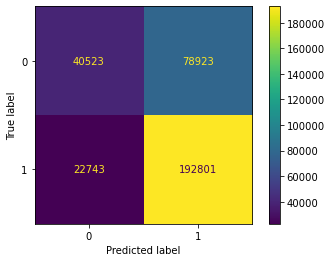

In [ ]:
from sklearn.metrics import roc_auc_score

def get_infer_dict(loader):
    model.eval()
    infer_dict = {}
    
    start_time = time.time()

    with torch.no_grad(): 
        ability_mus, item_feat_mus = [], []
        ability_logvars, item_feat_logvars = [], []

        pbar = tqdm(total=len(loader))
        for _, response, _, mask in loader:
            mb = response.size(0)
            response = response.to(device)
            mask = mask.long().to(device)

            _, ability_mu, ability_logvar, _, item_feat_mu, item_feat_logvar = \
                model.encode(response, mask)

            ability_mus.append(ability_mu.cpu())
            ability_logvars.append(ability_logvar.cpu())

            item_feat_mus.append(item_feat_mu.cpu())
            item_feat_logvars.append(item_feat_logvar.cpu())

            pbar.update()

        ability_mus = torch.cat(ability_mus, dim=0)
        ability_logvars = torch.cat(ability_logvars, dim=0)
        pbar.close()

    infer_dict['ability_mu'] = ability_mus
    infer_dict['ability_logvar'] = ability_logvars
    infer_dict['item_feat_mu'] = item_feat_mu
    infer_dict['item_feat_logvar'] = item_feat_logvar

    return infer_dict

def sample_posterior_predictive(loader):
    model.eval()
    meter = AverageMeter()
    pbar = tqdm(total=len(loader))
    
    start_time = time.time()

    with torch.no_grad():

        response_sample_set = []

        for _, response, _, mask in loader:
            mb = response.size(0)
            response = response.to(device)
            mask = mask.long().to(device)

            _, ability_mu, ability_logvar, _, item_feat_mu, item_feat_logvar = \
                model.encode(response, mask)

            ability_scale = torch.exp(0.5 * ability_logvar)
            item_feat_scale = torch.exp(0.5 * item_feat_logvar)

            ability_posterior = dist.Normal(ability_mu, ability_scale)
            item_feat_posterior = dist.Normal(item_feat_mu, item_feat_scale)

            ability_samples = ability_posterior.sample([num_posterior_samples])
            item_feat_samples = item_feat_posterior.sample([num_posterior_samples])

            response_samples = []
            for i in range(num_posterior_samples):
                ability_i = ability_samples[i]
                item_feat_i = item_feat_samples[i]
                response_i = model.decode(ability_i, item_feat_i).cpu()
                response_samples.append(response_i)
            response_samples = torch.stack(response_samples)
            response_sample_set.append(response_samples)

            pbar.update()

        response_sample_set = torch.cat(response_sample_set, dim=1)

        pbar.close()
        
    end_time = time.time()

    return {'response': response_sample_set, 'infer_time': end_time - start_time}

def sample_posterior_mean(loader):
    model.eval()
    meter = AverageMeter()
    pbar = tqdm(total=len(loader))
    
    start_time = time.time()
    
    with torch.no_grad():

        response_sample_set = []

        for _, response, _, mask in loader:
            mb = response.size(0)
            response = response.to(device)
            mask = mask.long().to(device)

            _, ability_mu, _, _, item_feat_mu, _ = \
                model.encode(response, mask)

            response_sample = model.decode(ability_mu, item_feat_mu).cpu()
            response_sample_set.append(response_sample.unsqueeze(0))

            pbar.update()

        response_sample_set = torch.cat(response_sample_set, dim=1)

        pbar.close()
    
    end_time = time.time()
    
    return {'response': response_sample_set, 'infer_time': end_time - start_time}

def run_inference_new_loader(train=False):
    dataset = train_dataset if train else test_dataset
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size, 
        shuffle = False,
    )
    for checkpoint_name in ['model_best.pth.tar']:
        checkpoint = torch.load(os.path.join(out_dir, checkpoint_name))
        model.load_state_dict(checkpoint['model_state_dict'])
        posterior_mean_samples = sample_posterior_mean(loader)
        checkpoint['posterior_mean_samples'] = posterior_mean_samples
        y_pred_prob = posterior_mean_samples['response'].squeeze(0).squeeze(2).numpy()
        y_pred = np.round(y_pred_prob)


def run_inference(train=True):
    dataset = train_dataset if train else test_dataset
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size, 
        shuffle = False,
    )
    
    # for checkpoint_name in ['checkpoint.pth.tar', 'model_best.pth.tar']:
    for checkpoint_name in ['model_best.pth.tar']:
        checkpoint = torch.load(os.path.join(out_dir, checkpoint_name))
        model.load_state_dict(checkpoint['model_state_dict'])

        # infer_dict = get_infer_dict(loader)
        # checkpoint['infer_dict'] = infer_dict
        
#         posterior_predict_samples = sample_posterior_predictive(loader)
#         checkpoint['posterior_predict_samples'] = posterior_predict_samples
        
#         if artificial_missing_perc > 0:
#             missing_indices = dataset.missing_indices
#             missing_labels = dataset.missing_labels
            
#             if np.ndim(missing_labels) == 1:
#                 missing_labels = np.round(missing_labels[:, np.newaxis])
                
#             y_pred_prob = posterior_predict_samples['response'].mean(0)
#             y_pred = np.round(y_pred_prob)
            
#             correct, count = 0, 0
#             predicted_labels = []
#             predicted_label_probs = []
#             for missing_index, missing_label in zip(missing_indices, missing_labels):
#                 predicted_label = y_pred[missing_index[0], missing_index[1]]
#                 if predicted_label.item() == missing_label[0]:
#                     correct += 1
#                 count += 1
#                 predicted_labels.append(predicted_label.item())
#                 predicted_label_probs.append(y_pred_prob[missing_index[0], missing_index[1]])
            
#             print('y_pred:', np.unique(predicted_labels, return_counts=True))
#             print('y:', np.unique(missing_labels.flatten(), return_counts=True))
            
#             missing_imputation_accuracy = correct / float(count)
#             checkpoint['missing_imputation_accuracy'] = missing_imputation_accuracy
#             print(f'Missing Imputation Accuracy from samples: {missing_imputation_accuracy}')
            
#             auc = roc_auc_score(missing_labels.flatten(), predicted_label_probs)
#             print("AUC: {:.2f}".format(auc))
            
#             cm = confusion_matrix(missing_labels.flatten(), predicted_labels)
#             print(cm)
#             disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
#             disp.plot()
            
#             print(f'Infer time:', posterior_predict_samples['infer_time'])

        posterior_mean_samples = sample_posterior_mean(loader)
        checkpoint['posterior_mean_samples'] = posterior_mean_samples
        
        if artificial_missing_perc > 0:
            missing_indices = dataset.missing_indices
            missing_labels = dataset.missing_labels
            
            if np.ndim(missing_labels) == 1:
                missing_labels = np.round(missing_labels[:, np.newaxis])
                
            y_pred_prob = posterior_mean_samples['response'].squeeze(0).squeeze(2).numpy()
            y_pred = np.round(y_pred_prob)
            
            correct, count = 0, 0
            predicted_labels = []
            predicted_label_probs = []
            for missing_index, missing_label in zip(missing_indices, missing_labels):
                predicted_label = y_pred[missing_index[0], missing_index[1]]
                if predicted_label.item() == missing_label[0]:
                    correct += 1
                count += 1
                predicted_labels.append(predicted_label.item())
                predicted_label_probs.append(y_pred_prob[missing_index[0], missing_index[1]])
            
            print('y_pred:', np.unique(predicted_labels, return_counts=True))
            print('y:', np.unique(missing_labels.flatten(), return_counts=True))
            
            missing_imputation_accuracy = correct / float(count)
            checkpoint['missing_imputation_accuracy'] = missing_imputation_accuracy
            print(f'Missing Imputation Accuracy from samples: {missing_imputation_accuracy}')
            
            auc = roc_auc_score(missing_labels.flatten(), predicted_label_probs)
            print("AUC: {:.2f}".format(auc))
            
            cm = confusion_matrix(missing_labels.flatten(), predicted_labels)
            print(cm)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot()
            
            print(f'Infer time:', posterior_mean_samples['infer_time'])
            
            
            
        
#         y_pred_prob = posterior_mean_samples['response'].squeeze(0).squeeze(2).numpy()
#         y_pred = np.round(y_pred_prob)
        
#         y_prob = dataset.responses
#         y = np.round(y_prob)
        
#         correct = (y_pred == y).sum()
#         count = (y != MISSING_DATA).sum()
#         accuracy = correct / float(count)
#         checkpoint['accuracy_from_mean'] = accuracy
#         print(f'Accuracy from mean: {accuracy}, Correct: {correct}, count: {count}')
        
#         mask = np.array(dataset.mask, dtype=bool)
#         print('y_pred:', np.unique(y_pred[mask], return_counts=True))
#         print('y:', np.unique(y, return_counts=True))
        
#         cm = confusion_matrix(y[mask].flatten(), y_pred[mask].flatten())
#         print(cm)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
#         disp.plot()
        
#         auc = roc_auc_score(y[mask], y_pred_prob[mask])
#         print("AUC: {:.2f}".format(auc))
        
#         print(f'Infer time:', posterior_mean_samples['infer_time'])

#         train_logp = get_log_marginal_density(data_loader)
#         checkpoint['train_logp'] = train_logp

#         if not no_test:
#             test_logp = get_log_marginal_density(test_loader)
#             checkpoint['test_logp'] = test_logp

        torch.save(checkpoint, os.path.join(out_dir, checkpoint_name))

run_inference(train=True)

# Best
# irt_model=2pl, ability_dim=8,
# y_pred: (array([0., 1.]), array([ 63155, 271835]))
# y: (array([0., 1.]), array([119446, 215544]))
# Missing Imputation Accuracy from samples: 0.6971700647780531
# AUC: 0.70
# [[ 40578  78868]
#  [ 22577 192967]]
# Infer time: 11.841894388198853

# References
1. https://github.com/mhw32/variational-item-response-theory-public